In [3]:
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

# # 데이터 다운로드
# data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
# data.to_csv('../data/aapl.csv')

# 백테스팅 전략 정의
class MACDStrategy(bt.Strategy):
    params = (
        ("macd1", 12),
        ("macd2", 26),
        ("macdsig", 9),
        ("order_pct", 0.95),
        ("log_file", "macd_strategy.csv")
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macdsig)
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        
    def next(self):
        if self.crossover > 0:
            self.buy(size=None)
        elif self.crossover < 0:
            self.close()
            
# 백테스팅 엔진 설정
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)  # 초기 자본 설정

# 데이터 피드 추가
datafeed = bt.feeds.YahooFinanceCSVData(dataname='../data/aapl.csv', reverse=False)
cerebro.adddata(datafeed)

# 전략 추가
cerebro.addstrategy(MACDStrategy)

# 백테스팅 실행
cerebro.run()

# 결과 시각화
cerebro.plot(iplot=False)


[[<Figure size 1920x1007 with 6 Axes>]]

                           Strategy
-------------------------  ----------
Start Period               2020-02-24
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             53.0%

Cumulative Return          0.06%
CAGR﹪                     0.02%

Sharpe                     0.79
Prob. Sharpe Ratio         90.78%
Smart Sharpe               0.78
Sortino                    1.16
Smart Sortino              1.15
Sortino/√2                 0.82
Smart Sortino/√2           0.81
Omega                      1.2

Max Drawdown               -0.03%
Longest DD Days            303
Volatility (ann.)          0.03%
Calmar                     0.52
Skew                       0.05
Kurtosis                   5.86

Expected Daily %           0.0%
Expected Monthly %         0.0%
Expected Yearly %          0.02%
Kelly Criterion            8.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.0%
Expected Shortfall (cVaR)  -0.0%

Max Consecutive Wins       7
Max Con

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-13,2022-06-30,2022-08-09,240,-0.029517,-0.027609
2,2022-10-31,2022-11-29,2022-12-30,61,-0.026037,-0.025807
3,2020-09-02,2021-03-30,2021-07-01,303,-0.023189,-0.022570
4,2021-07-15,2021-09-10,2021-11-18,127,-0.011683,-0.010044
5,2022-08-18,2022-10-20,2022-10-27,71,-0.009512,-0.009152


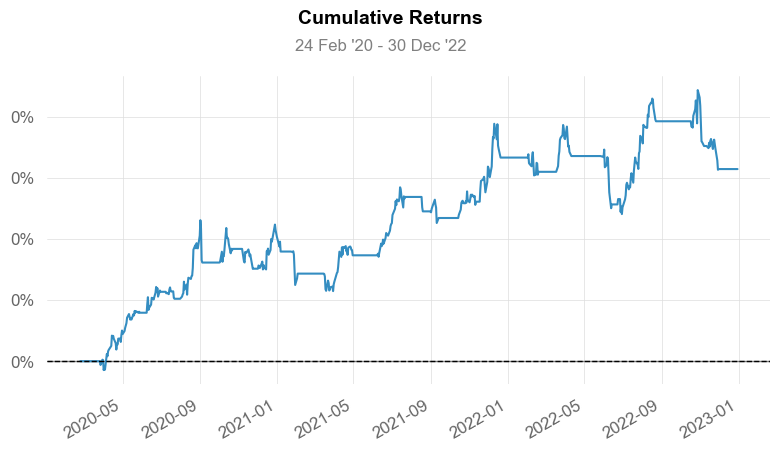

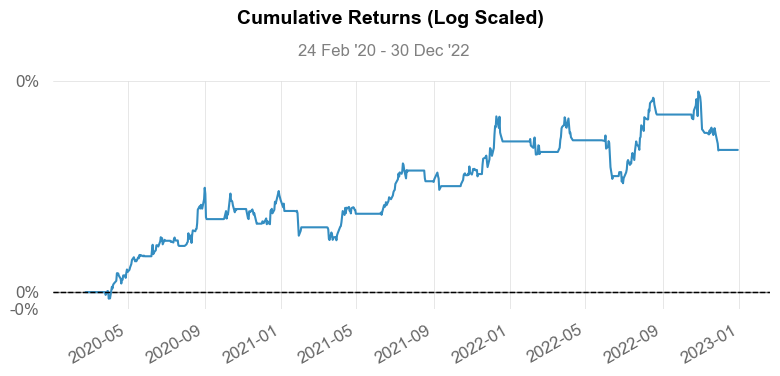

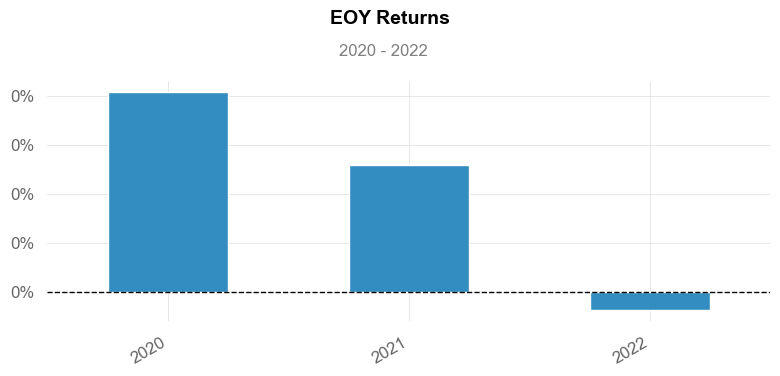

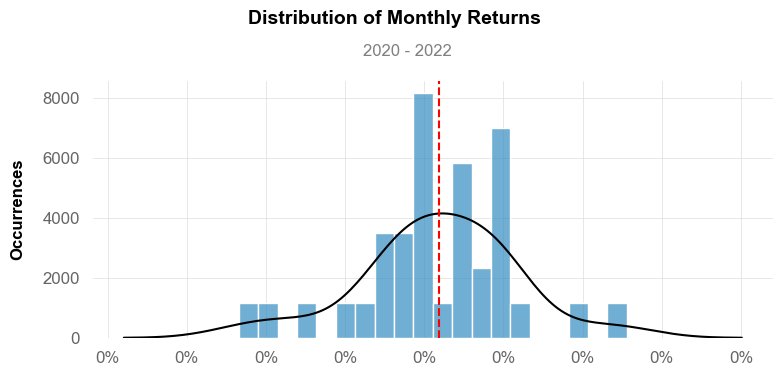

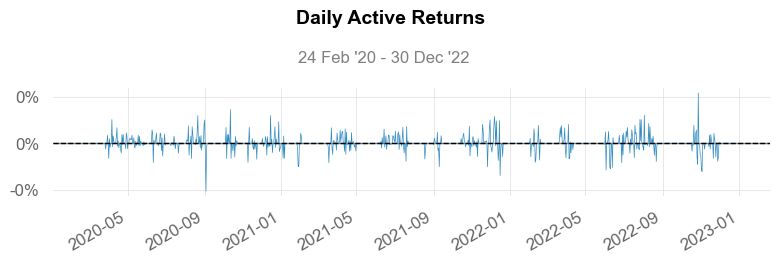

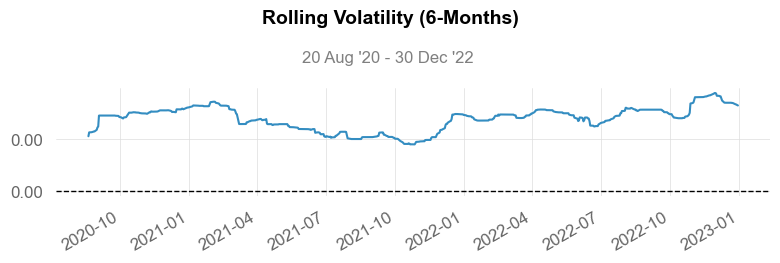

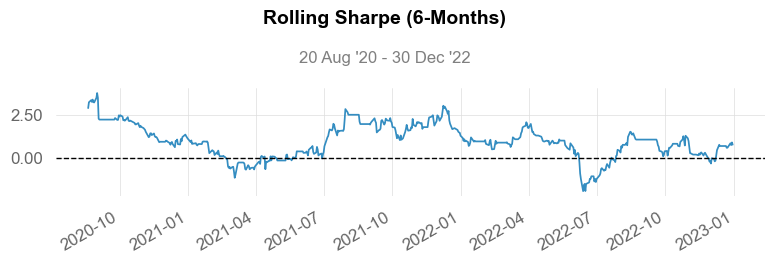

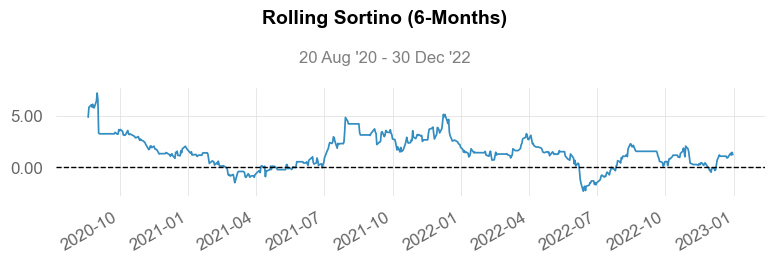

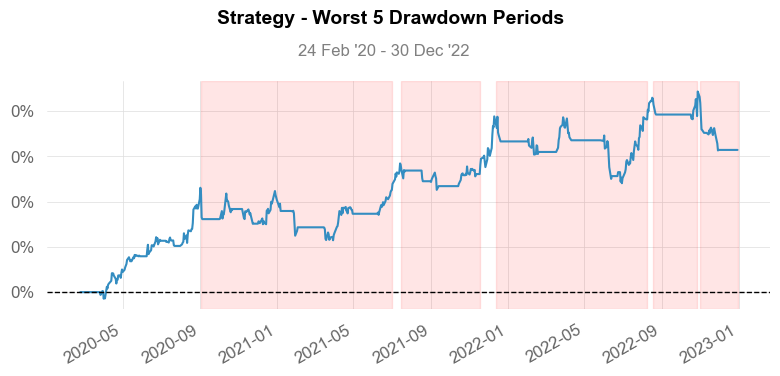

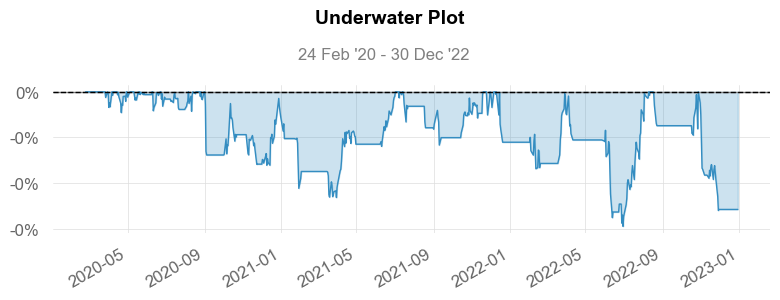

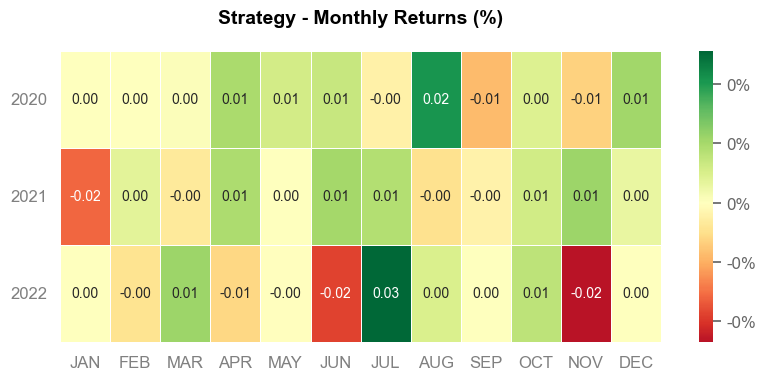

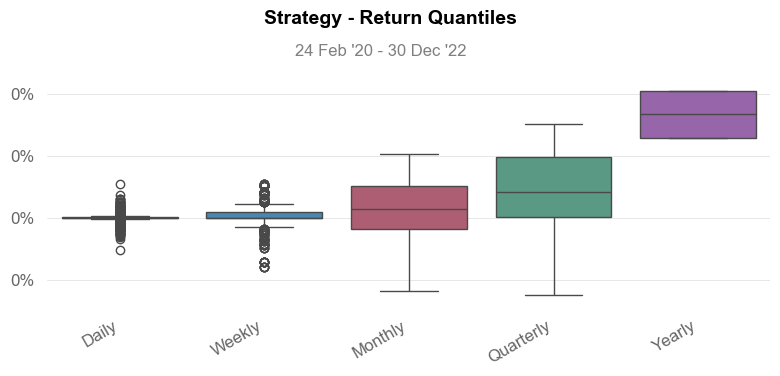

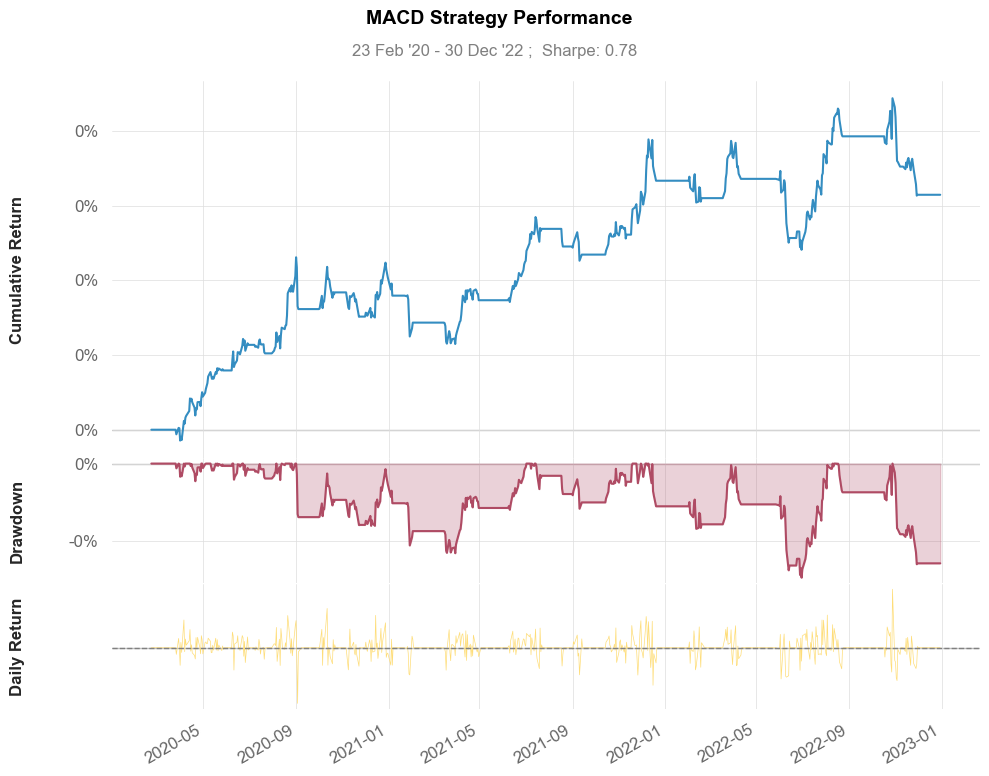

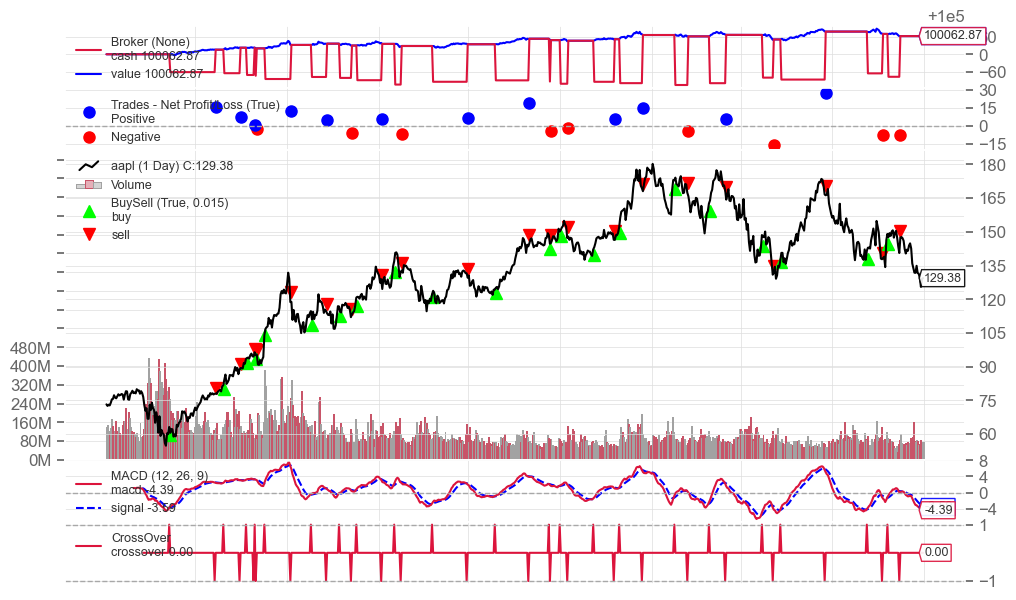

[[<Figure size 1000x600 with 6 Axes>]]

In [10]:
import backtrader as bt
import quantstats as qs
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# 백테스팅 전략 정의
class MACDStrategy(bt.Strategy):
    # MACD 전략을 정의하기 위해 사용할 매개변수들입니다.
    params = (
        ("macd1", 12),  # MACD의 단기 EMA 기간
        ("macd2", 26),  # MACD의 장기 EMA 기간
        ("macdsig", 9),  # MACD의 신호선 기간
        ("order_pct", 0.95),  # 주문 크기 (전체 자산의 비율로 지정)
        ("log_file", "macd_strategy.csv")  # 로깅 파일의 이름
    )
    
    def __init__(self):
        # MACD 지표를 생성합니다.
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macdsig)
        # MACD와 MACD 신호선의 교차 지점을 계산합니다.
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        
        # 로깅을 위한 파일을 열고, CSV 헤더를 작성합니다.
        self.log_file = open(self.params.log_file, 'w')
        self.log_file.write("Date,Value\n")
        
    def stop(self):
        # 전략이 종료되면 로깅 파일을 닫습니다.
        self.log_file.close()
        
    def next(self):
        # MACD와 MACD 신호선이 긍정적으로 교차하면 매수 주문을 생성합니다.
        if self.crossover > 0:
            self.buy(size=None)
        # MACD와 MACD 신호선이 부정적으로 교차하면 포지션을 청산합니다.
        elif self.crossover < 0:
            self.close()
            
        # 현재 포트폴리오 가치를 로깅합니다.
        self.log_file.write(f"{self.data.datetime.date(0)},{self.broker.getvalue()}\n")

# 백테스팅 엔진 설정
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)  # 초기 자본을 설정합니다.

# 데이터 피드 추가
datafeed = bt.feeds.YahooFinanceCSVData(dataname='../data/aapl.csv', reverse=False)
cerebro.adddata(datafeed)

# 전략 추가
cerebro.addstrategy(MACDStrategy)

# 백테스팅 실행
cerebro.run()

# 결과 분석 및 시각화
# 로깅된 포트폴리오 가치 데이터를 불러옵니다.
portfolio_stats = pd.read_csv("macd_strategy.csv", parse_dates=True, index_col='Date')

# 일일 수익률을 계산합니다.
portfolio_stats['returns'] = portfolio_stats['Value'].pct_change()

# quantstats로 결과 분석 및 시각화
# 주의: 'returns' 컬럼이 데이터프레임에 있어야 합니다.
qs.reports.full(portfolio_stats['returns'])
qs.plots.snapshot(portfolio_stats['returns'], title='MACD Strategy Performance')

cerebro.plot(iplot=False)



                           Strategy
-------------------------  ----------
Start Period               2020-02-24
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             53.0%

Cumulative Return          63.15%
CAGR﹪                     12.59%

Sharpe                     0.92
Prob. Sharpe Ratio         94.1%
Smart Sharpe               0.9
Sortino                    1.4
Smart Sortino              1.37
Sortino/√2                 0.99
Smart Sortino/√2           0.97
Omega                      1.24

Max Drawdown               -18.29%
Longest DD Days            308
Volatility (ann.)          21.05%
Calmar                     0.69
Skew                       0.33
Kurtosis                   6.49

Expected Daily %           0.07%
Expected Monthly %         1.41%
Expected Yearly %          17.72%
Kelly Criterion            9.77%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.1%
Expected Shortfall (cVaR)  -2.1%

Max Consecutive Wins       7
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-13,2022-06-30,2022-08-09,240,-18.290058,-17.022422
2,2020-09-02,2021-03-30,2021-07-06,308,-18.035634,-17.621342
3,2022-10-31,2022-11-30,2022-12-30,61,-16.241681,-16.212727
4,2021-07-15,2021-09-10,2021-11-22,131,-8.017342,-7.215370
5,2020-04-15,2020-04-21,2020-04-28,14,-6.097075,-3.931009


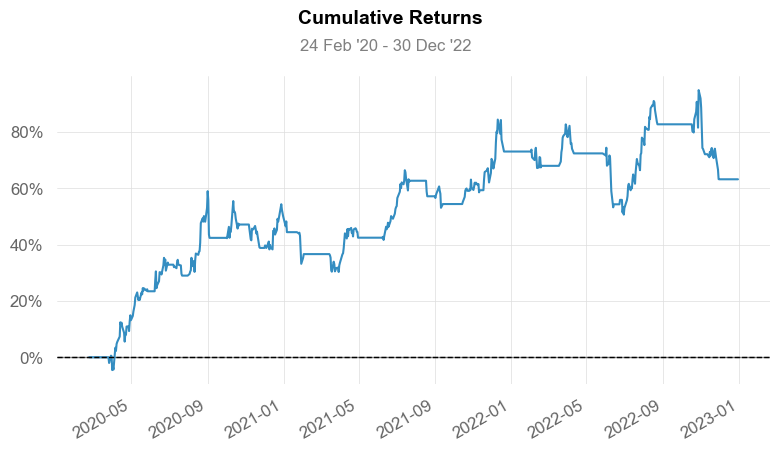

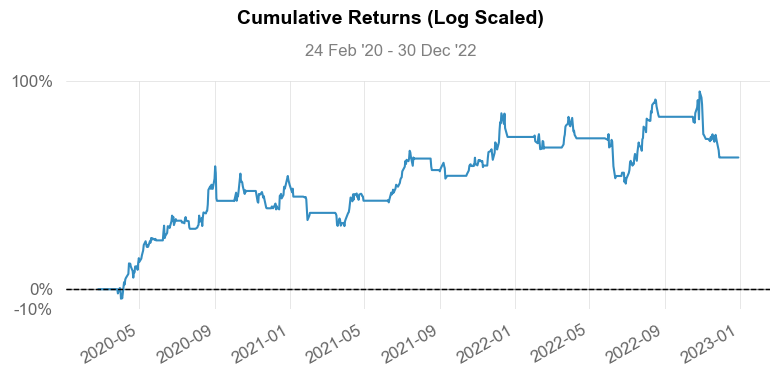

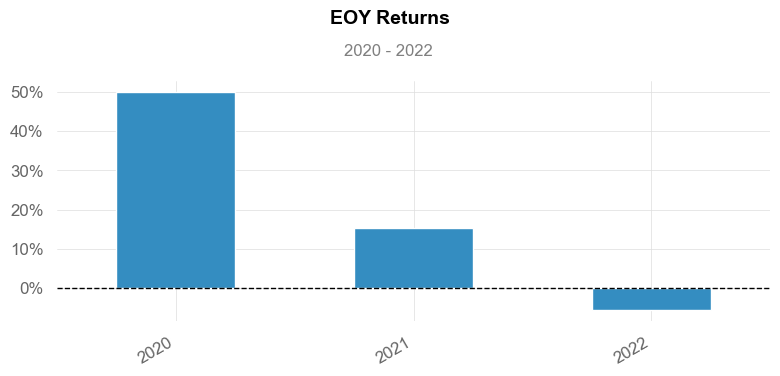

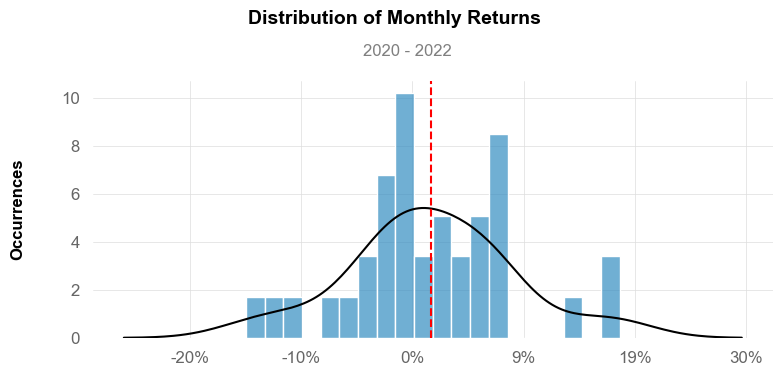

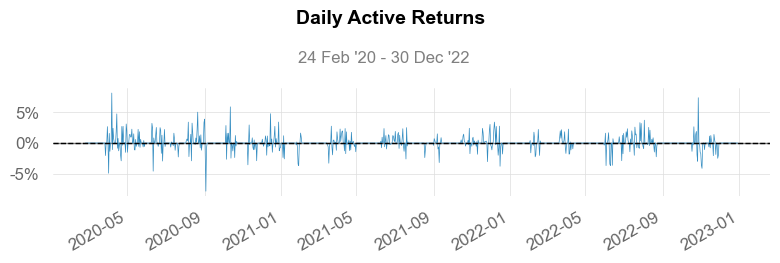

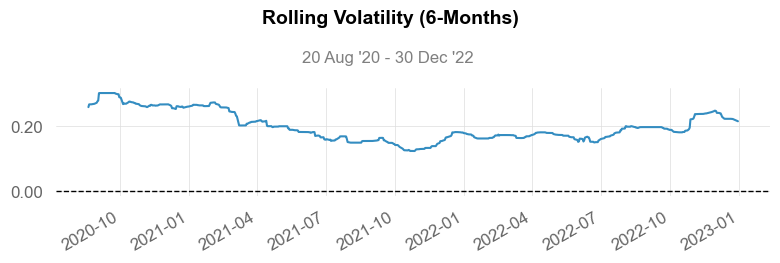

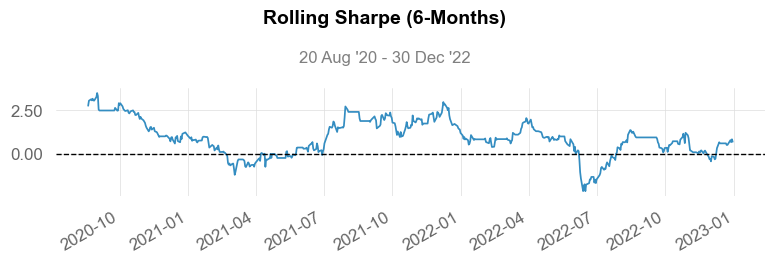

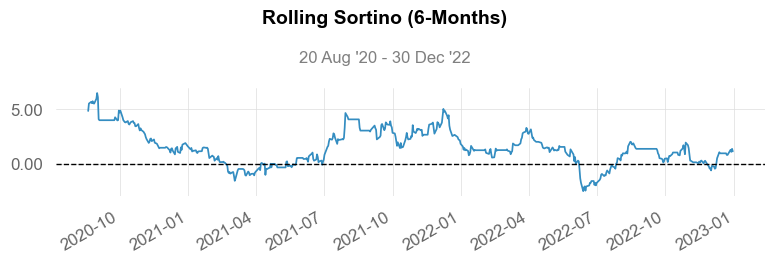

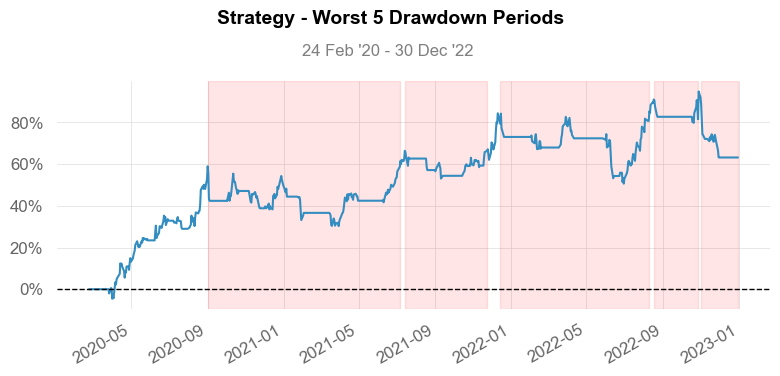

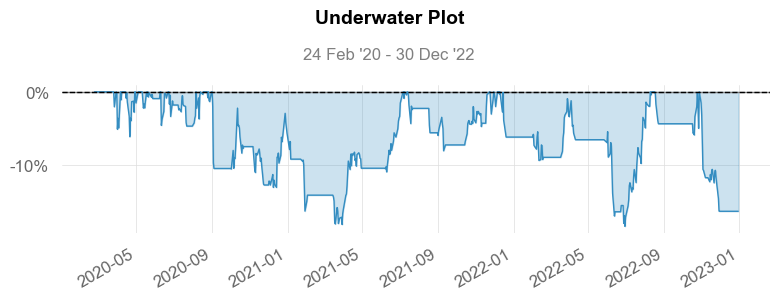

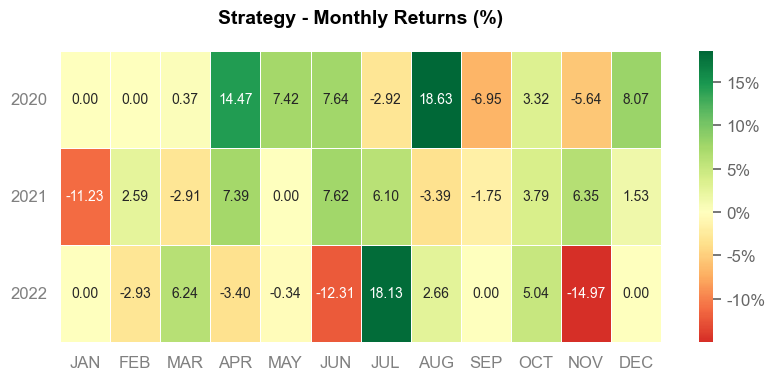

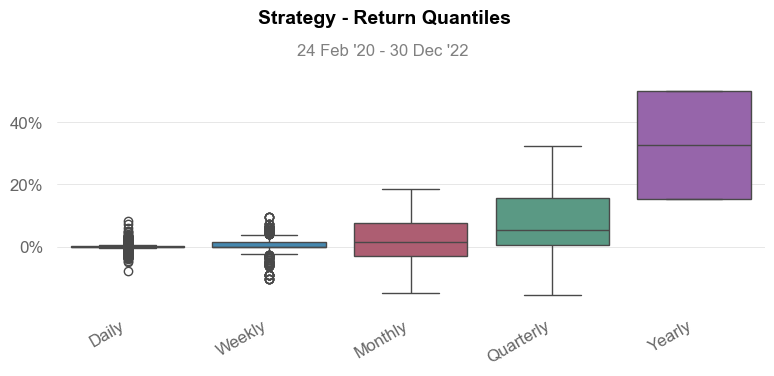

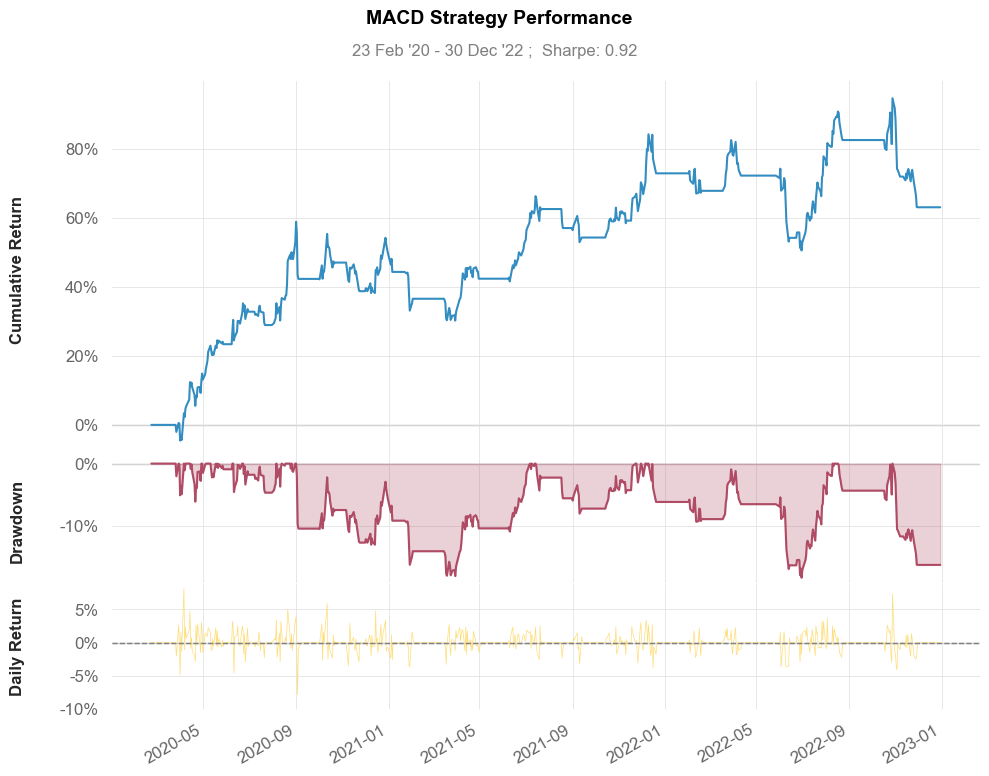

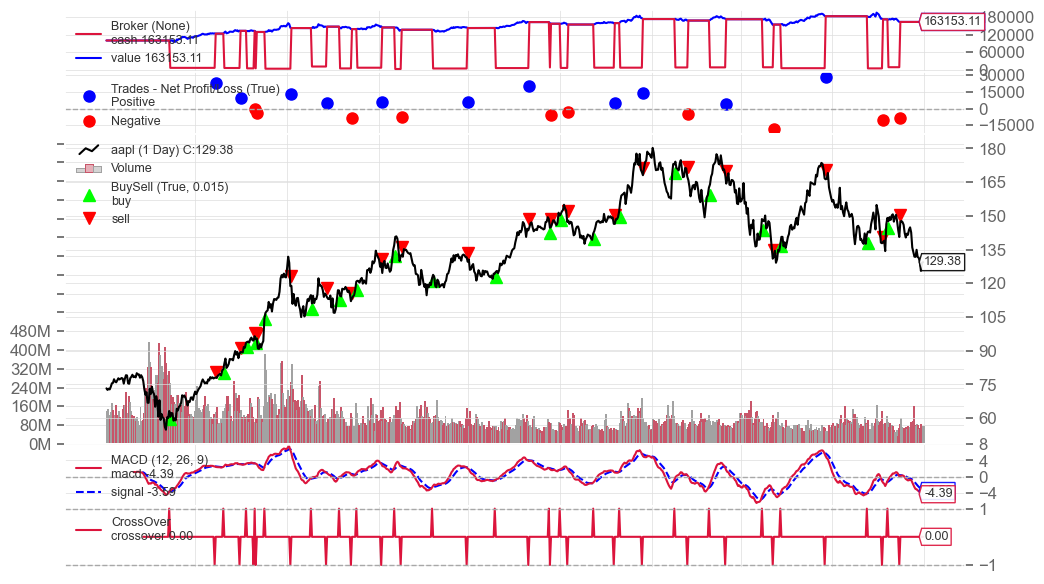

[[<Figure size 1000x600 with 6 Axes>]]

In [11]:
import backtrader as bt
import pandas as pd
import quantstats as qs
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 전략 정의
class MACDStrategy(bt.Strategy):
    params = (
        ("macd1", 12),
        ("macd2", 26),
        ("macdsig", 9),
        ("order_pct", 0.95),
        ("log_file", "macd_strategy.csv")
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macdsig)
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.log_file = open(self.params.log_file, 'w')
        self.log_file.write("Date,Value\n")
        
    def stop(self):
        self.log_file.close()
        
    def next(self):
        # 적절한 주문 크기 계산
        size = (self.broker.get_cash() * self.params.order_pct) // self.data.close[0]

        # 거래 로직
        if self.crossover > 0:
            self.buy(size=size)
        elif self.crossover < 0:
            self.close()
        
        # 로깅
        self.log_file.write(f"{self.data.datetime.date(0)},{self.broker.getvalue()}\n")


# 백테스팅 엔진 설정
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)  # 초기 자본 설정
cerebro.broker.set_slippage_perc(0.001)  # 슬리피지 설정
cerebro.broker.setcommission(commission=0.001)  # 수수료 설정

# 데이터 추가
# (데이터 경로와 형식이 올바른지 확인하세요!)
datafeed = bt.feeds.YahooFinanceCSVData(dataname='../data/aapl.csv', reverse=False)
cerebro.adddata(datafeed)

# 전략 추가
cerebro.addstrategy(MACDStrategy)

# 백테스팅 실행
cerebro.run()

# 결과 분석 및 시각화
portfolio_stats = pd.read_csv("macd_strategy.csv", parse_dates=True, index_col='Date')
portfolio_stats['returns'] = portfolio_stats['Value'].pct_change()
qs.reports.full(portfolio_stats['returns'])
qs.plots.snapshot(portfolio_stats['returns'], title='MACD Strategy Performance')
cerebro.plot(iplot=False)


In [12]:
import backtrader as bt
import pandas as pd
import quantstats as qs
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 전략 정의
class MACDStrategy(bt.Strategy):
    params = (
        ("macd1", 12),
        ("macd2", 26),
        ("macdsig", 9),
        ("order_pct", 0.95),
        ("log_file", "macd_strategy.csv")
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macdsig)
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.log_file = open(self.params.log_file, 'w')
        self.log_file.write("Date,Value\n")
        
    def stop(self):
        self.log_file.close()
        
    def next(self):
        # 적절한 주문 크기 계산
        size = (self.broker.get_cash() * self.params.order_pct) // self.data.close[0]

        # 거래 로직
        if self.crossover > 0:
            self.buy(size=size)
        elif self.crossover < 0:
            self.close()
        
        # 로깅
        self.log_file.write(f"{self.data.datetime.date(0)},{self.broker.getvalue()}\n")


# 백테스팅 엔진 설정
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)  # 초기 자본 설정
cerebro.broker.set_slippage_perc(0.001)  # 슬리피지 설정
cerebro.broker.setcommission(commission=0.001)  # 수수료 설정

# 데이터 추가
# (데이터 경로와 형식이 올바른지 확인하세요!)
datafeed = bt.feeds.YahooFinanceCSVData(dataname='../data/aapl.csv', reverse=False)
cerebro.adddata(datafeed)

# 전략 추가
cerebro.addstrategy(MACDStrategy)

# 백테스팅 실행
cerebro.run()

# 결과 분석 및 시각화
portfolio_stats = pd.read_csv("macd_strategy.csv", parse_dates=True, index_col='Date')
portfolio_stats['returns'] = portfolio_stats['Value'].pct_change()
qs.reports.full(portfolio_stats['returns'])
qs.plots.snapshot(portfolio_stats['returns'], title='MACD Strategy Performance')
cerebro.plot(iplot=False)
